In [1]:
!pip install -q -U watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.2 MB/s eta 0:00:00


In [2]:
# Reminder to upload the Zip file on Colab before starting

In [3]:
# Imports
import os
import time
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import sklearn
from sklearn.metrics import confusion_matrix

In [4]:
if torch.cuda.is_available():
    print("GPU number:", torch.cuda.device_count())
    print("GPU Model:", torch.cuda.get_device_name(0))
    print("GPU total memory [GB]:",torch.cuda.get_device_properties(0).total_memory / 1e9)

GPU number: 1
GPU Model: NVIDIA A100-SXM4-40GB
GPU total memory [GB]: 42.474471424


In [5]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [6]:
try:
    shutil.rmtree("EuroSAT_RGB")
    shutil.rmtree("__MACOSX")
    shutil.rmtree("train_images")
    shutil.rmtree("test_images")
except Exception as e:
    print(f"The folders do not exist or have already been deleted")

os.mkdir("train_images")
os.mkdir("test_images")

The folders do not exist or have already been deleted


In [ ]:
!unzip EuroSAT_RGB.zip

In [14]:
images_source = "EuroSAT_RGB"
train_dest = "train_images"
test_dest = "test_images"

image_class = 0
class_dict = {}
files = os.listdir(images_source)
files.sort()

for file_path in files:
    if file_path[0] != '.':
        images = os.listdir(images_source + '/' + file_path)
        sample_size = int(len(images) * 0.8)
        train = []
        final_dest = train_dest + '/' + str(image_class)
        os.mkdir(final_dest)
        for file_name in random.sample(images, sample_size):
            shutil.copy2(os.path.join(images_source, file_path, file_name), final_dest)
            train.append(file_name)
        test_images = list(set(images) - set(train))
        final_dest = test_dest + '/' + str(image_class)
        os.mkdir(final_dest)
        for test_image in test_images:
            shutil.copy2(os.path.join(images_source, file_path, test_image), final_dest)
        class_dict[image_class] = file_path
        image_class += 1

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.ImageFolder(root="train_images", transform=transform)

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

dataset_teste = torchvision.datasets.ImageFolder(root="test_images", transform=transform)

dl_test = torch.utils.data.DataLoader(dataset_teste, batch_size=1, shuffle=True, num_workers=2)

In [18]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [20]:
dataiter = iter(dl_train)
images, labels = next(dataiter)

In [21]:
mapping = {0:'AnnualCrop',
  1:'Forest',
  2:'HerbaceousVegetation',
  3:'Highway',
  4:'Industrial',
  5:'Pasture',
  6:'PermanentCrop',
  7:'Residential',
  8:'River',
  9:'SeaLake',
}

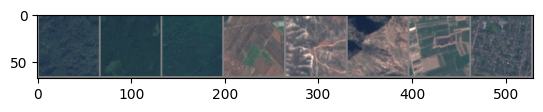

Labels: 1 1 1 6 2 2 6 7


In [22]:
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", " ".join("%d" % labels[j] for j in range(8)))

In [23]:
# Define a new model class named DSANet, inheriting from nn.Module
class DSANet(nn.Module):
    # Constructor method of the class
    def __init__(self):

       # Calls the constructor of the parent class (nn.Module)
        super(DSANet, self).__init__()

       # Defines the first convolutional layer with 3 input channels, 64 output channels,
       # and a kernel size of 3x3
        self.conv1 = nn.Conv2d(3, 64, 3, 1)

       # Defines the second convolutional layer with 64 input channels, 128 output channels,
       # and a kernel size of 3x3
        self.conv2 = nn.Conv2d(64, 128, 3, 1)

       # Defines the third convolutional layer with 128 input channels, 256 output channels,
       # and a kernel size of 3x3
        self.conv3 = nn.Conv2d(128, 256, 3, 1)

       # Defines the first dropout layer with a dropout probability of 0.25
        self.dropout1 = nn.Dropout(0.25)

       # Defines the second dropout layer with a dropout probability of 0.5
        self.dropout2 = nn.Dropout(0.5)

       # Defines the first fully connected layer (Dense), mapping from 215296 to 2048 neurons
        self.fc1 = nn.Linear(215296, 2048)

       # Defines the second fully connected layer, mapping from 2048 to 512 neurons
        self.fc2 = nn.Linear(2048, 512)

       # Defines the third fully connected layer, mapping from 512 to 128 neurons
        self.fc3 = nn.Linear(512, 128)

       # Defines the fourth fully connected layer, mapping from 128 to 10 neurons
        self.fc4 = nn.Linear(128, 10)
    # Defines the forward method for forward propagation
    def forward(self, x):

       # Applies the first convolutional layer
        x = self.conv1(x)

       # Applies the ReLU activation function
        x = F.relu(x)

       # Applies the second convolutional layer
        x = self.conv2(x)

       # Applies the ReLU activation function
        x = F.relu(x)

       # Applies the third convolutional layer
        x = self.conv3(x)

       # Applies the ReLU activation function
        x = F.relu(x)

       # Applies max pooling with a kernel size of 2x2
        x = F.max_pool2d(x, 2)

       # Applies the first dropout layer
        x = self.dropout1(x)

       # Flattens the tensor to prepare it for the fully connected layer
        x = torch.flatten(x, 1)

       # Applies the first fully connected layer
        x = self.fc1(x)

       # Applies the ReLU activation function
        x = F.relu(x)

       # Applies the second dropout layer
        x = self.dropout2(x)

       # Applies the second fully connected layer
        x = self.fc2(x)

       # Applies the ReLU activation function
        x = F.relu(x)

       # Applies the third fully connected layer
        x = self.fc3(x)

       # Applies the ReLU activation function
        x = F.relu(x)

       # Applies the fourth fully connected layer
        x = self.fc4(x)

       # Returns the softmax of the resulting tensor along dimension 1 (commonly used for classification)
        return F.log_softmax(x, dim=1)

In [33]:
model = DSANet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [34]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

num_epochs = 30

testiter = iter(dl_test)

In [35]:
%%time
print('Training Started!')

# Iterate over the number of epochs
for epoch in range(num_epochs):

    # Initialize the variable to accumulate loss over the epoch
    running_loss = 0.0

    # Initialize a batch counter
    i = 0

    # Iterate over training data with a progress bar (tqdm)
    for data in (pbar := tqdm(dl_train)):

        # Update the progress bar description to show the current epoch
        pbar.set_description(f"\nEpoch {epoch}")

        # Unpack the batch of data into inputs and labels
        inputs, labels = data

        # Move inputs and labels to the correct device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero out gradients in the optimizer
        optimizer.zero_grad()

        # Forward pass through the neural network
        outputs = model(inputs)

        # Calculate loss using the defined criterion
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        loss.backward()

        # Update neural network weights using the optimizer
        optimizer.step()

        # Update the accumulated loss value
        running_loss += loss.item()

        # Initialize counters for the correct number of predictions and total samples
        total_correct = 0
        total_samples = 0

        # If we're on a batch multiple of 100
        if i % 100 == 0:

            # Disable gradient calculation to save memory and processing time
            with torch.no_grad():

                # Get a batch of test images and labels
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # Perform a forward pass through the neural network with 8 test images
                test_outputs = model(test_images[:8])

                # Get predictions for the 8 images
                _, predicted = torch.max(test_outputs, 1)

        # Increment the batch counter
        i += 1

    # Display the average loss for the epoch
    print(f"Epoch {epoch}, Loss: {running_loss / (i)}")

print('Training Completed!')

Training Started!


Epoch 0: 100%|██████████| 338/338 [00:18<00:00, 17.99it/s]


Epoch 0, Loss: 1.1751919134834108


Epoch 1: 100%|██████████| 338/338 [00:17<00:00, 19.50it/s]


Epoch 1, Loss: 0.6816159257521996


Epoch 2: 100%|██████████| 338/338 [00:17<00:00, 19.44it/s]


Epoch 2, Loss: 0.5281849094837375


Epoch 3: 100%|██████████| 338/338 [00:17<00:00, 19.44it/s]


Epoch 3, Loss: 0.39009219028893305


Epoch 4: 100%|██████████| 338/338 [00:17<00:00, 19.49it/s]


Epoch 4, Loss: 0.29269580688525937


Epoch 5: 100%|██████████| 338/338 [00:17<00:00, 19.48it/s]


Epoch 5, Loss: 0.2001351782688375


Epoch 6: 100%|██████████| 338/338 [00:17<00:00, 19.47it/s]


Epoch 6, Loss: 0.1666232774408876


Epoch 7: 100%|██████████| 338/338 [00:17<00:00, 19.52it/s]


Epoch 7, Loss: 0.12387390497840456


Epoch 8: 100%|██████████| 338/338 [00:17<00:00, 19.47it/s]


Epoch 8, Loss: 0.10172142607253595


Epoch 9: 100%|██████████| 338/338 [00:17<00:00, 19.45it/s]


Epoch 9, Loss: 0.08701246481915087


Epoch 10: 100%|██████████| 338/338 [00:17<00:00, 19.47it/s]


Epoch 10, Loss: 0.07958871125623848


Epoch 11: 100%|██████████| 338/338 [00:17<00:00, 19.48it/s]


Epoch 11, Loss: 0.07476114742692075


Epoch 12: 100%|██████████| 338/338 [00:17<00:00, 19.50it/s]


Epoch 12, Loss: 0.07809843339498523


Epoch 13: 100%|██████████| 338/338 [00:17<00:00, 19.47it/s]


Epoch 13, Loss: 0.06252386864204477


Epoch 14: 100%|██████████| 338/338 [00:17<00:00, 19.50it/s]


Epoch 14, Loss: 0.04746982108263613


Epoch 15: 100%|██████████| 338/338 [00:17<00:00, 19.50it/s]


Epoch 15, Loss: 0.04240791278003685


Epoch 16: 100%|██████████| 338/338 [00:17<00:00, 19.50it/s]


Epoch 16, Loss: 0.051939043290630676


Epoch 17: 100%|██████████| 338/338 [00:17<00:00, 19.49it/s]


Epoch 17, Loss: 0.0555136018634294


Epoch 18: 100%|██████████| 338/338 [00:17<00:00, 19.48it/s]


Epoch 18, Loss: 0.07341870447753697


Epoch 19: 100%|██████████| 338/338 [00:17<00:00, 19.49it/s]


Epoch 19, Loss: 0.03555454754161431


Epoch 20: 100%|██████████| 338/338 [00:17<00:00, 19.56it/s]


Epoch 20, Loss: 0.040311275370788935


Epoch 21: 100%|██████████| 338/338 [00:17<00:00, 19.56it/s]


Epoch 21, Loss: 0.035413854420229006


Epoch 22: 100%|██████████| 338/338 [00:17<00:00, 19.51it/s]


Epoch 22, Loss: 0.02592506587356205


Epoch 23: 100%|██████████| 338/338 [00:17<00:00, 19.41it/s]


Epoch 23, Loss: 0.03473329630982787


Epoch 24: 100%|██████████| 338/338 [00:17<00:00, 19.41it/s]


Epoch 24, Loss: 0.03441417311588075


Epoch 25: 100%|██████████| 338/338 [00:17<00:00, 19.44it/s]


Epoch 25, Loss: 0.05094854880974455


Epoch 26: 100%|██████████| 338/338 [00:17<00:00, 19.47it/s]


Epoch 26, Loss: 0.04475372398849971


Epoch 27: 100%|██████████| 338/338 [00:17<00:00, 19.46it/s]


Epoch 27, Loss: 0.02602977859329021


Epoch 28: 100%|██████████| 338/338 [00:17<00:00, 19.50it/s]


Epoch 28, Loss: 0.031122593469424385


Epoch 29: 100%|██████████| 338/338 [00:17<00:00, 19.43it/s]

Epoch 29, Loss: 0.04575850293876365
Training Completed!
CPU times: user 8min 25s, sys: 18.1 s, total: 8min 43s
Wall time: 8min 42s


In [37]:
total_correct = 0
total_samples = 0
model.eval()

with torch.no_grad():
    for data in (pbar := tqdm(dl_test)):
        pbar.set_description(f"Evaluating the model.")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct +=  (predicted == labels).sum().item()

accuracy = total_correct/total_samples
print(accuracy)

Evaluating the model.: 100%|██████████| 5400/5400 [00:19<00:00, 271.34it/s]


0.8548148148148148


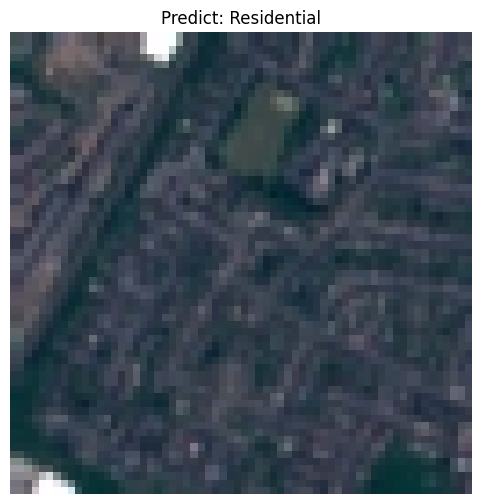

In [40]:
with torch.no_grad():
    data_iter = iter(dl_test)
    data = next(data_iter)
    inputs, _ = data
    image = inputs[0].unsqueeze(0)
    image = image.to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    image_numpy = image.cpu().numpy()[0]
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    if image_numpy.shape[2] == 1:
        image_numpy = np.squeeze(image_numpy, axis=2)
    elif image_numpy.shape[2] == 3:
        image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())

    plt.figure(figsize=(6, 6))
    plt.imshow(image_numpy)
    plt.title(f'Predict: {mapping[predicted.item()]}')
    plt.axis('off')
    plt.show()